In [48]:
import tensorflow_advanced_segmentation_models as tasm
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

In [49]:
main_path = "C:/Users/SEBASTIAN/OneDrive - Universidad de los Andes/OctavoSemestre/Robocol_vision/Img/prueba_segmentacion/"

x_train_dir = main_path + 'train_x/'
y_train_dir = main_path + 'train_y/'
x_valid_dir = main_path + 'val_x/'
y_valid_dir = main_path + 'val_y/'
x_test_dir = main_path + 'test_x/'
y_test_dir = main_path + 'test_y/'

### Helper functions

In [50]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

### Data augmentation functions

In [51]:
# define heavy augmentations
def get_training_augmentation(height, width):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        A.RandomCrop(height=height, width=width, always_apply=True),

        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(height, width):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(height, width),
        A.Resize(height, width, always_apply=True)
    ]
    return A.Compose(test_transform)

def data_get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### Define some global variables

In [52]:
###########Asi deberia de ser###############
#Total_classes = ['Rocks','Terrain','People','Building','Robot','Sky','Trees','Station S','WhatEver']
#N_total_classes = 9
############################################
Total_classes = ['rocks','station','background']
N_total_classes = 3

#Classes_pixel_count_dict = {"Rocks":346,'Terrain':818301,'People':15709988,'Building':140525,'Robot':250492,
#                            'Sky':807478,'Trees':4485973,'Station S':2201037,'WhatEver':2733,'noKnow':123848,
#                            'noKnow2':35279}

Classes_pixel_count_dict = {'rocks':620848,'station':56432,'background':17754720}



MODEL_CLASSES = Total_classes
ALL_CLASSES = False
if MODEL_CLASSES == Total_classes:
    ALL_CLASSES = True

batch_size = 2
N_classes = len(Total_classes)
#HEIGHT = 480
#WIDTH = 640
HEIGHT = 240
WIDTH = 320
backbone_name = "efficientnetb3"
weights = "imagenet"
wwo_aug = True # train data with and without augmentation

### Functions to calculate appropriate class weights

In [53]:
################################################################################
# Class Weights
################################################################################
def get_dataset_counts(d):
    pixel_count = np.array([i for i in d.values()])

    sum_pixel_count = 0
    for i in pixel_count:
        sum_pixel_count += i

    return pixel_count, sum_pixel_count

def get_dataset_statistics(pixel_count, sum_pixel_count):
    
    pixel_frequency = np.round(pixel_count / sum_pixel_count, 4)

    mean_pixel_frequency = np.round(np.mean(pixel_frequency), 4)

    return pixel_frequency, mean_pixel_frequency

def get_balancing_class_weights(classes, d):
    pixel_count, sum_pixel_count = get_dataset_counts(d)

    background_pixel_count = 0
    mod_pixel_count = []

    for c in Total_classes:
        if c not in classes:
            background_pixel_count += d[c]
        else:
            mod_pixel_count.append(d[c])

    if not ALL_CLASSES:
        mod_pixel_count.append(background_pixel_count)
    else:
        mod_pixel_count[:-1]
    
    pixel_frequency, mean_pixel_frequency = get_dataset_statistics(mod_pixel_count, sum_pixel_count)

    class_weights = np.round(mean_pixel_frequency / pixel_frequency, 2)
    return class_weights    

class_weights = get_balancing_class_weights(MODEL_CLASSES, Classes_pixel_count_dict)
print(class_weights)

[  9.89 107.55   0.35]


### Data Generation Functions

In [54]:
################################################################################
# Data Generator
################################################################################
def create_image_label_path_generator(images_dir, masks_dir, shuffle=False, seed=None):
    ids = sorted(os.listdir(images_dir))
    mask_ids = sorted(os.listdir(masks_dir))

    if shuffle == True:

        if seed is not None:
            tf.random.set_seed(seed)

        indices = tf.range(start=0, limit=tf.shape(ids)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        ids = tf.gather(ids, shuffled_indices).numpy().astype(str)
        mask_ids = tf.gather(mask_ids, shuffled_indices).numpy().astype(str)

    images_fps = [os.path.join(images_dir, image_id) for image_id in ids]
    masks_fps = [os.path.join(masks_dir, image_id) for image_id in mask_ids]

    while True:
        for i in range(len(images_fps)):
            yield [images_fps[i], masks_fps[i]]


def process_image_label(images_paths, masks_paths, classes, augmentation=None, preprocessing=None, all_classes=False):
    class_values = [Total_classes.index(cls.lower()) for cls in classes]
    
    # read data
    image = cv2.imread(images_paths)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_paths, 0)

    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in class_values]
    mask = np.stack(masks, axis=-1).astype('float')
    
    # add background if mask is not binary
    if mask.shape[-1] != 1 and not all_classes:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)
    
    # apply augmentations
    if augmentation:
        sample = augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if preprocessing:
        sample = preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # mask = np.squeeze(np.argmax(mask, axis=-1))
    # mask = np.argmax(mask, axis=-1)
    # mask = mask[..., np.newaxis]
        
    return image, mask

def DataGenerator(train_dir, label_dir, batch_size, height, width, classes, augmentation, all_classes=False, wwo_aug=False, shuffle=False, seed=None):
    image_label_path_generator = create_image_label_path_generator(
        train_dir, label_dir, shuffle=shuffle, seed=seed
    )
    if wwo_aug:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            if all_classes:
                labels = np.zeros(shape=[batch_size, height, width, len(classes)], dtype=np.float32)
            else:
                labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(0, batch_size, 2):
                image_path, label_path = next(image_label_path_generator)
                image_aug, label_aug = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation, all_classes=all_classes)
                image_wo_aug, label_wo_aug = process_image_label(image_path, label_path, classes=classes, augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH), all_classes=all_classes)
                images[i], labels[i] = image_aug, label_aug
                images[i + 1], labels[i + 1] = image_wo_aug, label_wo_aug

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)
    else:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            if all_classes:
                labels = np.zeros(shape=[batch_size, height, width, len(classes)], dtype=np.float32)
            else:
                labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(batch_size):
                image_path, label_path = next(image_label_path_generator)
                image, label = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation, all_classes=all_classes)
                images[i], labels[i] = image, label

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)

### Create the Model

In [56]:
base_model, layers, layer_names = tasm.create_base_model(name=backbone_name, weights=weights, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.DANet(n_classes=N_classes, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

### Define the optimizer as well as losses, metrics and callbacks

In [57]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss(class_weights=class_weights)

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

### Get the Data

In [58]:
train_shuffle = True
val_shuffle = True
seed = 29598

TrainSetwwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    batch_size,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    wwo_aug=True,
    shuffle=train_shuffle,
    seed=seed
)

ValidationSet = DataGenerator(
    x_valid_dir,
    y_valid_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=val_shuffle,
    seed=seed
)

TestSet = DataGenerator(
    x_test_dir,
    y_test_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=False
)

for i in TrainSetwwoAug:
    sample_image, sample_mask = i[0][0], i[1][0]
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

print(len(os.listdir(x_train_dir)))
print(len(os.listdir(x_valid_dir)))
print(len(os.listdir(x_test_dir)))


2
(2, 240, 320, 3)
(2, 240, 320, 3)
48
6
6


SparseCategoricalCrossentroy: 1.1836138
Iou-Score: 1.1337775
categorical Focal Dice Loss: -0.634506


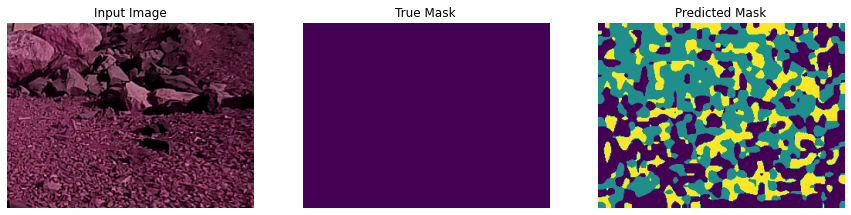

In [59]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    output_model = model(sample_image[tf.newaxis, ...])
    # print(output_model.numpy())
    
    output_mask = create_mask(output_model)
    # print(sample_mask.shape)

    scce = tf.keras.losses.CategoricalCrossentropy()
    print("SparseCategoricalCrossentroy: " + str(scce(sample_mask, output_model[0]).numpy()))
    # print(iou_score(sample_mask, output_model[0]))
    print("Iou-Score: " + str(tasm.losses.iou_score(sample_mask[tf.newaxis, ...], output_model, class_weights=class_weights).numpy()))
    # print("Dice Loss: " + str(dice_loss(sample_mask, output_model[0]).numpy()))
    # print("Categorical Focal Loss: " + str(categorical_focal_loss(sample_mask, output_model[0]).numpy()))
    print("categorical Focal Dice Loss: " + str(categorical_focal_dice_loss(sample_mask[tf.newaxis, ...], output_model).numpy()))
    
    display([sample_image, tf.argmax(sample_mask, axis=-1)[..., tf.newaxis], output_mask]) # K.one_hot(K.squeeze(output_mask, axis=-1), 3)])
    
show_predictions()

In [60]:
for layer in model.layers:
    if "functional" in layer.name:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))

up_sampling2d_3: True
model_3: True
convolution_bn_activation_33: True
convolution_bn_activation_34: True
pam__module_3: True
cam__module_3: True
convolution_bn_activation_38: True
convolution_bn_activation_39: True
dropout_9: True
dropout_10: True
dropout_11: True
convolution_bn_activation_40: True
convolution_bn_activation_41: True
convolution_bn_activation_42: True
concatenate_10: True
concatenate_11: True
convolution_bn_activation_43: True


In [61]:
if wwo_aug:
    steps_per_epoch = np.floor(len(os.listdir(x_train_dir)) / batch_size) * 2
else:
    steps_per_epoch = np.floor(len(os.listdir(x_train_dir)) / batch_size)

history = model.fit(
    TrainSetwwoAug,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=callbacks,
    )

Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[2,10240,10240] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Exp]

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()